In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# import SummaryWriter
from torch.utils.tensorboard import SummaryWriter

# import the MNIST dataset
import torchvision.datasets as datasets
from torchvision import transforms

import torchsummary

from sklearn.model_selection import train_test_split

# from torchdiffeq import odeint, odeint_adjoint

import cv2
import numpy as np

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from tqdm.notebook import trange

In [2]:
from utils import ConvAE, create_gaussian_dataset, gaussian_density
from ball import Ball

In [3]:
def grid_samples(k, size, r_min, r_max, margin=1.):
    samples = []
    indices_matrix = np.array([[i,j] for i in range(size) for j in range(size)])
    # print(indices_matrix)
    # print(indices_matrix.shape)
    eps = 1E-5
    step = (size - 2.*margin)/k
    positions_x = np.arange(margin, size - 1 - margin, step)
    positions_y = np.arange(margin, size - 1 - margin, step)
    for x in positions_x:
        for y in positions_y:
            r = np.random.uniform(r_min, r_max+eps)
            # create a gaussian ball
            image = np.zeros((size, size), dtype=np.float32)
            position = np.array([x, y])
            
            # compute the density over the image and normalize it
            image = gaussian_density(indices_matrix, position, r).numpy().copy()
            samples.append((image.reshape(1, size, size), np.array([x/(size ), y/(size)])))
        
    return samples

def plot_grid(ax, positions):
    # print(positions)
    plt.figure(figsize=(8, 8))
    # add line to the grid
    dim_positions = positions.shape[0]
    dim_positions = int(np.sqrt(dim_positions))
    try_pos = positions.reshape(dim_positions,dim_positions,2)
    ax.plot(try_pos[:,:,0], try_pos[:,:,1], 'k-', linewidth=0.5)
    ax.plot(try_pos[:,:,1], try_pos[:,:,0], 'k-', linewidth=0.5)
    ax.scatter(positions[:,0], positions[:,1], s=6)

def plot_square_transformation(model, square_samples, title):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    with torch.no_grad():
        pred_positions = np.array([model.encoder_linear(model.encode(torch.tensor(image).float().unsqueeze(0))).numpy()[0] for image, _ in square_samples])
        # add overall title
        ax[0].set_title("Inputs")
        ax[1].set_title(title)
        true_positions = np.array([position for _, position in square_samples])
        plot_grid(ax[0], true_positions)
        plot_grid(ax[1], pred_positions)
        plt.show()

In [4]:
def train(model, dataloader_train, dataloader_test, optimizer, scheduler, criterion, epochs=10, display_step=1):
    
    iterator = trange(epochs)
    losses_train = []
    losses_test = []
    sum_writer = SummaryWriter("runs/AE_image_loss_only")
    grid = grid_samples(16, 28, 1., 1., margin=1)


    for _ in iterator:
        loss_epoch = 0
        model.train()
        for i, data in enumerate(dataloader_train):
            image, _ = data
            image = image.float()
            # position = position.float()
            optimizer.zero_grad()
            output, position_pred = model(image)
            loss = criterion(image.squeeze(), output.squeeze())
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
            if i % display_step == 0:
                iterator.set_description(f'Batch: {i}/{len(dataloader_train)}, Loss: {loss_epoch/(i+1):.6f}')
                sum_writer.add_scalar('Loss/train', loss_epoch/(i+1), i)
                

            

        losses_train.append(loss_epoch/len(dataloader_train))
        model.eval()
        with torch.no_grad():
            loss_epoch = 0
            for i, data in enumerate(dataloader_test):
                image, _ = data
                image = image.float()
                # position = position.float()    
                output, position_pred = model(image)
                loss = criterion(image.squeeze(), output.squeeze())
                loss_epoch += loss.item()
                if i % display_step == 0:
                    iterator.set_postfix_str(f'Test Batch: {i}/{len(dataloader_test)}, Loss: {loss_epoch/(i+1):.6f}')
                    sum_writer.add_scalar('Loss/test', loss_epoch/(i+1), i)
            
            losses_test.append(loss_epoch/len(dataloader_test))

            # plot_square_transformation(model, grid, "Grid tranformation at step {}".format(i))
        
        scheduler.step()
        
    return losses_train, losses_test

In [103]:
class WassersteinLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        return torch.mean(x) - torch.mean(y)
    
class GaussianLoss(nn.Module):
    def __init__(self, size=28):
        super().__init__()
        self.indices = torch.tensor([[i,j] for i in range(size) for j in range(size)])
        
    def forward(self, input_image, output_image):
        input_image = input_image.squeeze().float()
        output_image = output_image.squeeze().float()

        # print("input image", input_image.shape)
        # print("indices", self.indices.shape)
        # mean_input = torch.stack([input_image[batch, self.indices[:,0], self.indices[:,1]]@self.indices.float()
        #                 for batch in range(input_image.shape[0])], dim=0)
        # mean_output = torch.stack([output_image[batch, self.indices[:,0], self.indices[:,1]]@self.indices.float()
        #                 for batch in range(output_image.shape[0])], dim=0)

        # print('mean_input', mean_input.shape)
        # print("indices matrix", self.indices.float().T@self.indices.float())
        # # print("right", (input_image[0, self.indices[:,0], self.indices[:,1]]*self.indices.float()).shape)
        # loss_mean = torch.linalg.norm(mean_input - mean_output, dim=1)
        # loss_mean = torch.mean(loss_mean)
        # # print(input_image[0, self.indices].shape)
        # # print(output_image[:, self.indices].shape)
        # print("vector in the indices order", input_image[0, self.indices.T].shape)
        # var_input = torch.stack([self.indices.float().T@input_image[batch, self.indices]*self.indices.float() - mean_input[batch].T@mean_input[batch]
        #                 for batch in range(input_image.shape[0])])
        # var_output = torch.stack([output_image[batch, self.indices[:,0], self.indices[:,1]]@self.indices.float().T@self.indices.float() - mean_output[batch].T@mean_output[batch]
        #                 for batch in range(output_image.shape[0])])

        # print(var_input.shape)
        # print("var_output", var_output.shape)
        # print("indices@indices", (self.indices.float()@self.indices.float().T).shape)
        # print("mean@mean.T",(mean_input[0]@mean_input[0].T).shape)
        # loss_var = torch.mean(torch.linalg.norm(var_input - var_output, dim=(1,2), ord='fro'))/self.indices.shape[0]
        mean_input = torch.stack([input_image[batch, self.indices[:,0], self.indices[:,1]]@self.indices.float() for batch in range(input_image.shape[0]) ], dim=0)
        mean_output = torch.stack([input_image[batch, self.indices[:,0], self.indices[:,1]]@self.indices.float() for batch in range(output_image.shape[0]) ], dim=0)
        var_output = torch.zeros((output_image.shape[0], self.indices.shape[1], self.indices.shape[1]))
        var_input = torch.zeros((input_image.shape[0], self.indices.shape[1], self.indices.shape[1]))

        # # compute the covariance matrix
        # for batch in range(output_image.shape[0]): 
        #     for i in range(self.indices.shape[0]):
        #         for j in range(self.indices.shape[0]):
        #             var_input[batch] += (input_image[batch, self.indices[i,0], self.indices[i,1]]*(self.indices[i,:] - mean_input[batch])).unsqueeze(-1)@(input_image[batch, self.indices[j,0], self.indices[j,1]]*(self.indices[j,:] - mean_input[batch])).unsqueeze(-1).T
        #             var_output[batch] += (output_image[batch, self.indices[i,0], self.indices[i,1]]*(self.indices[i,:] - mean_output[batch])).unsqueeze(-1)@(output_image[batch, self.indices[j,0], self.indices[j,1]]*(self.indices[j,:] - mean_output[batch])).unsqueeze(-1).T
        #     var_input[batch] /= self.indices.shape[0] - 1
        #     var_output[batch] /= self.indices.shape[0] - 1

        loss_mean = torch.mean(torch.norm(mean_input - mean_output, dim=1))
        # loss_var = torch.mean(torch.norm(var_input - var_output, dim=(1,2), ord='fro'))
        return loss_mean #+ loss_var

class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.gaussianloss = GaussianLoss()
        self.kl = nn.KLDivLoss()
        self.img_loss = nn.MSELoss()

    def forward(self, input_image, output_image):
        input_image = input_image.squeeze().float()
        output_image = output_image.squeeze().float()
        loss_img = self.img_loss(input_image, output_image)
        loss_kl = self.kl(input_image, output_image)
        loss_gaussian = self.gaussianloss(input_image, output_image)
        return 784*loss_img - loss_kl + loss_gaussian

customGaussianloss = GaussianLoss()
wassertein = WassersteinLoss()
kl = nn.KLDivLoss()
gaussianloss = nn.GaussianNLLLoss()
loss_fn = CustomLoss()

In [104]:
img = torch.zeros((3,1,28,28))
noisy_img = (img + 0.1*torch.randn_like(img))*0
print(img.shape, noisy_img.shape)
size = 28
batch = 0 

indices = torch.tensor([[i,j] for i in range(size) for j in range(size)])

input_image = img.squeeze().float()
output_image = noisy_img.squeeze().float()

print(customGaussianloss(input_image, output_image))

print("input image", input_image.shape)
print("indices", indices.shape)
mean_input = torch.stack([input_image[batch, indices[:,0], indices[:,1]]@indices.float()
            for batch in range(input_image.shape[0])], dim=0)
mean_output = torch.stack([output_image[batch, indices[:,0], indices[:,1]]@indices.float()
            for batch in range(output_image.shape[0])], dim=0)

print('mean_input', mean_input.shape)
print("indices matrix", indices.float().T@indices.float())
# print("right", (input_image[0, self.indices[:,0], self.indices[:,1]]*self.indices.float()).shape)
loss_mean = torch.linalg.norm(mean_input - mean_output, dim=1)
loss_mean = torch.mean(loss_mean)
# print(input_image[0, self.indices].shape)
# print(output_image[:, self.indices].shape)
print("vector in the indices order", input_image[0, indices[:,0], indices[:,1]].shape)
print('first ope', (input_image[batch, indices[:,0], indices[:,1]]*(indices.float() - mean_input[batch])).shape)
# compute the covariance matrix estimation
var_input = torch.stack([
    (input_image[batch, indices[:,0], indices[:,1]]*(indices.float() - mean_input[batch])).unsqueeze(-1)@((indices.float() - mean_input[batch])).unsqueeze(-1).T/(indices.shape[0]-1)
    for batch in range(input_image.shape[0])
])
print(var_input.shape)
# var_input = torch.stack([indices.float().T@input_image[batch, indices[:,0], indices[:,1]]*indices.float() - mean_input[batch].T@mean_input[batch]
#             for batch in range(input_image.shape[0])])
var_output = torch.stack([
    (indices.float().T@output_image[batch, indices[:,0], indices[:,1]] - mean_output[batch]).unsqueeze(-1)@(indices.float().T@output_image[batch, indices[:,0], indices[:,1]] - mean_output[batch]).unsqueeze(-1).T/(indices.shape[0]-1)
    for batch in range(output_image.shape[0])
])

print(var_input.shape)
print("var_output", var_output.shape)
print("indices@indices", (indices.float()@indices.float().T).shape)
print("mean@mean.T",(mean_input[0]@mean_input[0].T).shape)
print(var_input)
print(var_output)
loss_var = torch.mean(torch.linalg.norm(var_input - var_output, dim=(1,2), ord='fro'))/indices.shape[0]
print(loss_var)

torch.Size([3, 1, 28, 28]) torch.Size([3, 1, 28, 28])
tensor(0.)
input image torch.Size([3, 28, 28])
indices torch.Size([784, 2])
mean_input torch.Size([3, 2])
indices matrix tensor([[194040., 142884.],
        [142884., 194040.]])
vector in the indices order torch.Size([784])


RuntimeError: The size of tensor a (784) must match the size of tensor b (2) at non-singleton dimension 1

In [141]:
dataset = create_gaussian_dataset(r_min=3., r_max=3, n_samples=10000, size=28, margin=3)

In [142]:
# split the dataset 
train_set, test_set = train_test_split(dataset, test_size=0.3, random_state=42)

# create dataloaders
dataloader_train = DataLoader(train_set, batch_size=16, shuffle=True)
dataloader_test = DataLoader(test_set, batch_size=64, shuffle=True)

In [143]:
model = ConvAE(height=28, width=28, latent_dim=3)

Number of parameters in the model: 222692


In [146]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

In [148]:
train(model, dataloader_train, dataloader_test, optimizer, scheduler, loss_fn, epochs=100, display_step=10)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

Position predicted : [ 0.        0.       30.344532] | True position : [0.72506718 0.1215514 ]


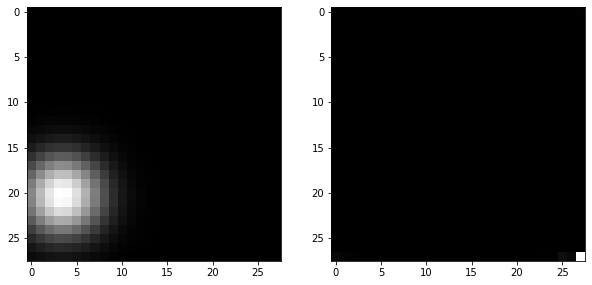

Position predicted : [ 0.        0.       30.366596] | True position : [0.20646939 0.77606794]


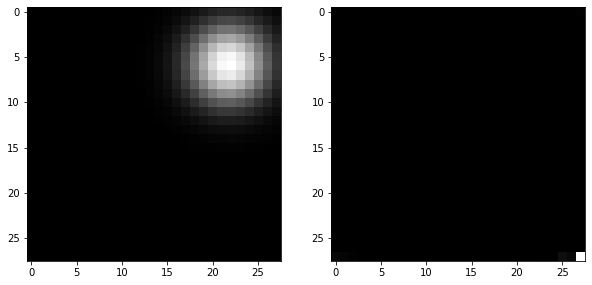

Position predicted : [ 0.       0.      30.34322] | True position : [0.74898056 0.71045601]


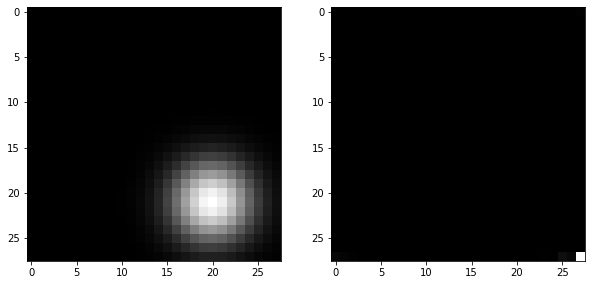

Position predicted : [ 0.        0.       30.509197] | True position : [0.18109823 0.43896773]


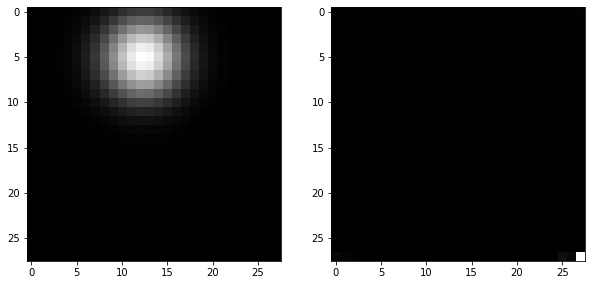

Position predicted : [ 0.       0.      30.40852] | True position : [0.1551391  0.67832725]


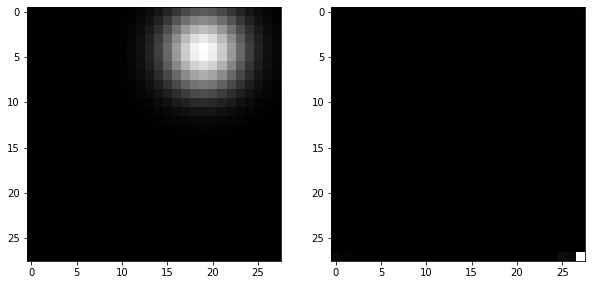

Position predicted : [ 0.        0.       30.551704] | True position : [0.3088426  0.36840887]


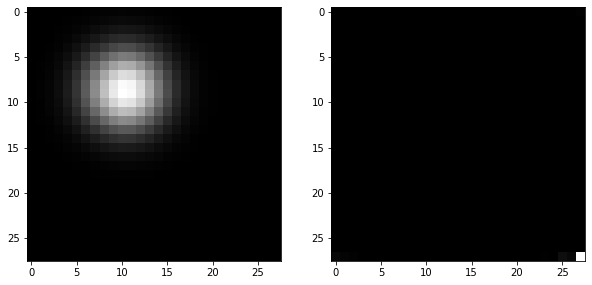

In [149]:
images = [image for image, _ in test_set]
for i, index in enumerate([0, len(images)//5, len(images)//4, len(images)//2, 3*len(images)//4, -1]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    pred_image, pred_position = model(torch.tensor(images[index]).float().unsqueeze(0))
    pred_image = pred_image.detach().numpy()
    pred_position = pred_position.detach().numpy()

    print(f"Position predicted : {pred_position[0,:]} | True position : {test_set[index][1][:]}")
    # print(f"Radius predicted : {pred_position[0,2]} | Radius position : {samples[index][1][2]}")
    ax[0].imshow(np.squeeze(images[index]), cmap='gray')
    ax[1].imshow(pred_image.squeeze(), cmap='gray')
    plt.show()

Position predicted : [0.         0.         0.         0.02019435 0.         0.
 0.01284909 0.00744364 0.         0.        ] | True position : [0.33655291 0.36988726]


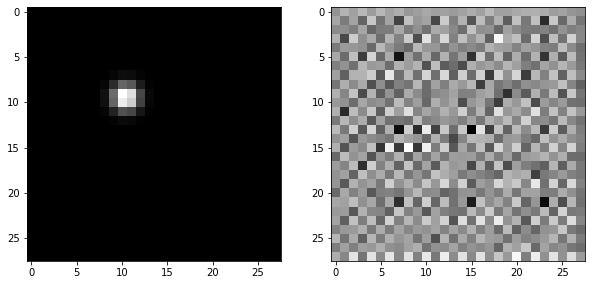

Position predicted : [0.         0.         0.         0.0200395  0.         0.
 0.01264097 0.00774126 0.         0.        ] | True position : [0.24835274 0.51664012]


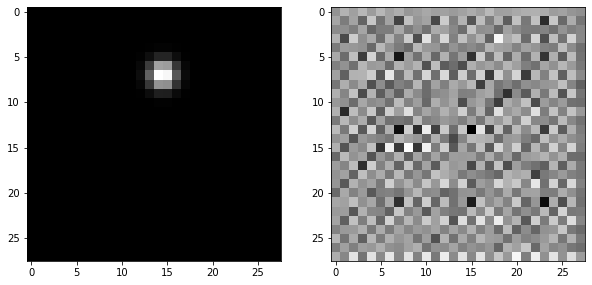

Position predicted : [0.         0.         0.         0.02015358 0.         0.
 0.0123921  0.00663426 0.         0.        ] | True position : [0.48793809 0.5415693 ]


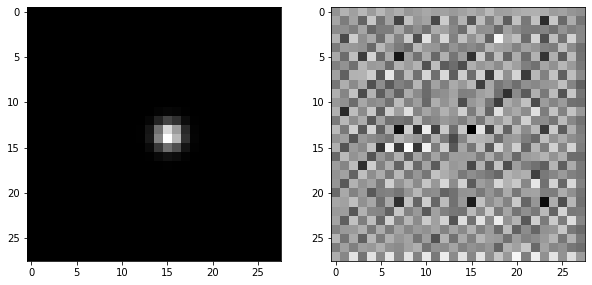

Position predicted : [0.         0.         0.         0.01997508 0.         0.
 0.01304702 0.0065843  0.         0.        ] | True position : [0.65248192 0.07922346]


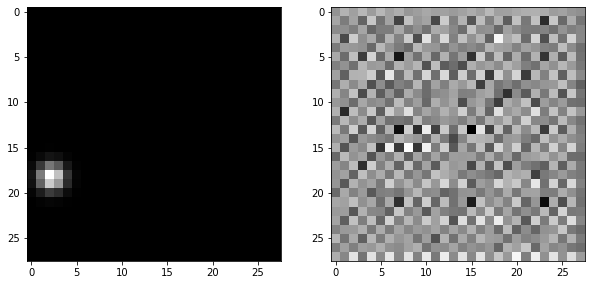

Position predicted : [0.         0.         0.         0.01975413 0.         0.
 0.01284656 0.00671469 0.         0.        ] | True position : [0.81283107 0.73072283]


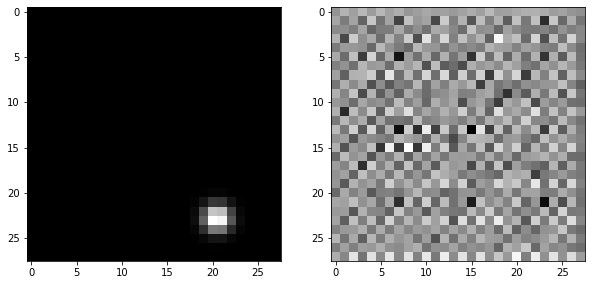

Position predicted : [0.         0.         0.         0.02053116 0.         0.
 0.01333187 0.00690511 0.         0.        ] | True position : [0.73564233 0.79219956]


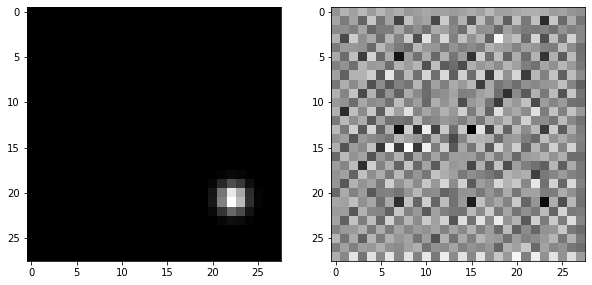

In [59]:
images = [image for image, _ in test_set]
for i, index in enumerate([0, len(images)//5, len(images)//4, len(images)//2, 3*len(images)//4, -1]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    pred_image, pred_position = model(torch.tensor(images[index]).float().unsqueeze(0))
    pred_image = pred_image.detach().numpy()
    pred_position = pred_position.detach().numpy()

    print(f"Position predicted : {pred_position[0,:]} | True position : {test_set[index][1][:]}")
    # print(f"Radius predicted : {pred_position[0,2]} | Radius position : {samples[index][1][2]}")
    ax[0].imshow(np.squeeze(images[index]), cmap='gray')
    ax[1].imshow(pred_image.squeeze(), cmap='gray')
    plt.show()

In [12]:
img = torch.from_numpy(datasets[0][0]).float().unsqueeze(0)
noisy_img = (img + 0.001*torch.randn_like(img))*1
img.shape, noisy_img.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 1, 28, 28]))

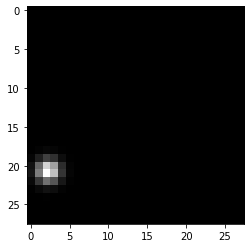

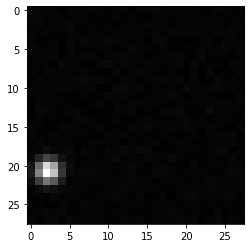

In [13]:
plt.imshow(img.squeeze().detach().numpy(), cmap='gray')
plt.show()
plt.imshow(noisy_img.squeeze().detach().numpy(), cmap='gray')
plt.show()


In [204]:
loss_fn(img, noisy_img)

(tensor(0.0008), tensor(0.0062), tensor(0.7386))